In [2]:
# Load modules
%matplotlib inline


import numpy as np
import os, sys
sys.path.insert(0, 'functions/')

import sms_fluxes
import gsw

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmocean.cm as cmo

import glidertools as gt

import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes ,InsetPosition,mark_inset
import cmocean.cm as cmo

from scipy.interpolate import griddata as g



/Users/isabelle/anaconda3/envs/giddy2020/lib/python3.8/site-packages/glidertools/mapping.py:1336: GliderToolsWarning: PyKrige is not installed. To enable the variogram function please run `pip install pykrige`. Variograms are required for sensible 2D interpolation.
  warnings.warn(message, category=GliderToolsWarning)


In [3]:
from matplotlib import rc
rc('font',**{'size':14})
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

import seaborn as sns






In [4]:
# All data loaded with intake
import intake
cat = intake.open_catalog('giddy_2020_data.yaml')

#cat.items() #to view the data

In [5]:
# Glider data - sg643
# This data has already been interpolated
dat = cat.sg643_pressure_levels.read()

SA=(dat.salt)
CT=(dat.temp)
rho=(dat.dens)
depth=dat.depth
lat=(dat.lat[15,:])
lon=(dat.lon[15,:])
dist=(dat.distance)
glider_dir=np.array(sms_fluxes.calc_glider_traj(lat,lon)) # Glider Trajectory
time=pd.Series(dat.time[15,:])

In [6]:
mld = pd.Series(sms_fluxes.calc_mld(np.array(rho),np.array(depth),ref_depth=10))  #Mixed Layer Depth

# TS diagram for determination of isopycnals associated with the different water masses : WW and uCDW. 

In [7]:
import gsw
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

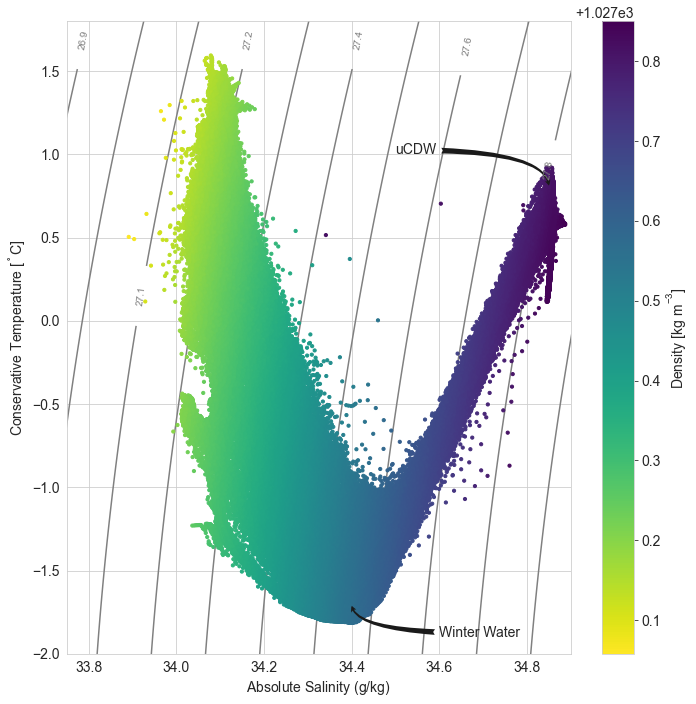

In [64]:
tsub=CT
ssub=SA

mint=np.nanmin(tsub)
maxt=np.nanmax(tsub)
mins=np.nanmin(ssub)
#maxs=np.nanmax(ssub)

mint=-1.8
maxt=2
mins=33.8
maxs=34.9

tempL=np.linspace(mint-1,maxt+1,156)
salL=np.linspace(mins-1,maxs+1,156)
Tg, Sg = np.meshgrid(tempL,salL)
sigma_theta = gsw.sigma0(Sg, Tg)
cnt = np.linspace(np.nanmin(sigma_theta), np.nanmax(sigma_theta),156)
fig,ax=plt.subplots(figsize=(10,10))
#fig.suptitle(‘programmer:Hafez Ahmad’, fontsize=14, fontweight=’bold’)
levels=np.arange(26.5,28,0.1)
cs = ax.contour(Sg, Tg, sigma_theta,levels=levels, colors='grey', zorder=1)
cl=plt.clabel(cs,fontsize=10,inline=True,fmt='%.1f')

sc=plt.scatter(np.array(ssub).flatten(),np.array(tsub).flatten(),c=rho,s=10,cmap='viridis_r')
cb=plt.colorbar(sc)
ax.set_xlabel('Absolute Salinity ($g/kg$)')
ax.set_ylabel('Conservative Temperature [$^\circ$C]')
#ax.set_title(‘General T-S (Temperature and salinity) Diagram’,fontsize=14, fontweight=’bold’)
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
ax.yaxis.set_major_locator(MaxNLocator(nbins=8))
ax.tick_params(direction='out')
cb.ax.tick_params(direction='out')
ax.set_xlim(33.75,34.9)
ax.set_ylim(-2,1.8)


cb.set_label('Density [kg m$^{-3}$]')


ax.annotate('Winter Water', xy=(34.4,-1.7),  xycoords='data',
            xytext=(34.6,-1.9),fontsize=14,
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.1", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90"))

ax.annotate('uCDW', xy=(34.85,0.8),  xycoords='data',
            xytext=(34.5,1),fontsize=14,
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.1", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90"))


plt.tight_layout()

#plt.savefig('figures/ts_plot.png',bbox_inches='tight',dpi=75)


# Comparison of the nearby SOCCOM float with the Seaglider observed Mixed Layer Depth

In [5]:
# Load SOCCOM float - could do this using argopy. 
datadir='data/'
ds=xr.open_dataset(os.path.join(datadir,'argo/5904467_Sprof.nc'))

df_soccom_dpt = pd.DataFrame(ds.PRES_ADJUSTED.values.T)
df_soccom_dpt = df_soccom_dpt.rename(columns=pd.Series(ds.JULD.values))
df_soccom = pd.DataFrame(ds.JULD.values)
df_soccom['Lon'] = pd.DataFrame(ds.LONGITUDE.values)
df_soccom['Lat'] = pd.DataFrame(ds.LATITUDE.values)
df_soccom = df_soccom.rename(columns={0: "Time"})
from tqdm import tqdm_notebook


ts = df_soccom['Time']
up_prof=[]
prof_no=np.arange(len(ts))
#prof_no
for i, val in enumerate(np.unique(ts)):
    
    ind = ts==val
    up_prof+=prof_no[ind][0],
    
df_soccom_up = df_soccom.loc[up_prof]

pres=df_soccom_dpt.values[:, up_prof]
temp=ds.TEMP_ADJUSTED.values[up_prof, :]
salt=ds.PSAL_ADJUSTED.values[up_prof, :]
rho=gsw.pot_rho_t_exact(salt,temp,pres.T,0)

from scipy.interpolate import griddata

temp_soccom = np.ndarray([1000, len(temp)])
salt_soccom = np.ndarray([1000, len(temp)])
rho_soccom = np.ndarray([1000, len(temp)])
z=np.arange(1000)
for i in tqdm_notebook(range(len(temp))):
    
    temp_soccom[:, i] = griddata(pres[:, i], temp[i, :], z, method='linear')
    salt_soccom[:, i] = griddata(pres[:, i], salt[i, :], z, method='linear')
    rho_soccom[:, i] = griddata(pres[:, i], rho[i, :], z, method='linear')
    
dates = [pd.to_datetime(d) for d in ds.JULD.values]


mld_SOCCOM=[]
for i in range(len(ds.JULD.values[up_prof])):
    try: mld_SOCCOM.append(z[(np.abs((rho_soccom[:,i]-rho_soccom[20,i]))>=0.03)].min())
    except ValueError:  #raised if `y` is empty.
        mld_SOCCOM.append(np.nan)
mld_SOCCOM=np.array(mld_SOCCOM)
mld_SOCCOM=pd.Series(mld_SOCCOM)

<ipython-input-5-9d11630540e9>:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(temp))):


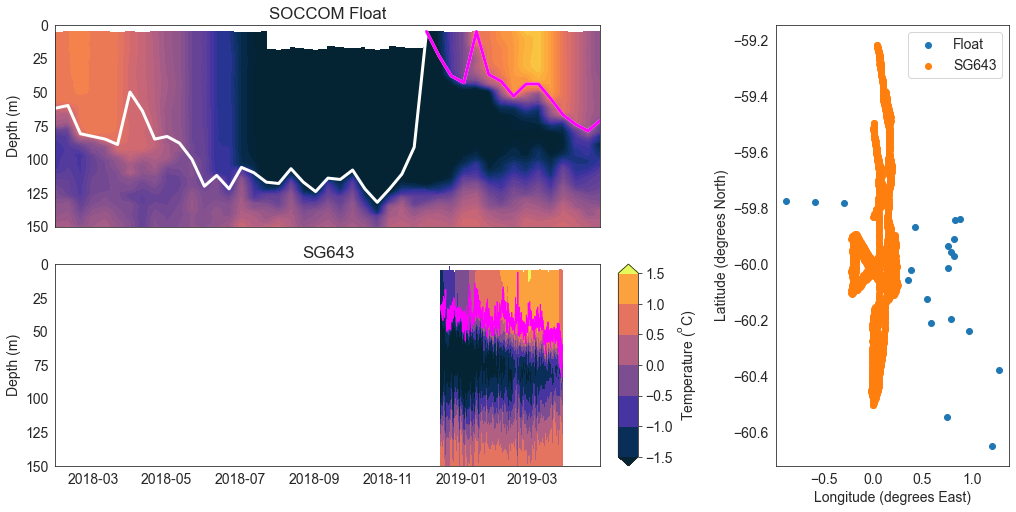

In [10]:
import cmocean.cm as cmo
import matplotlib.gridspec as gridspec

sns.set_style('white')



fig = plt.figure(figsize=[14,7],constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig,width_ratios=[0.7,0.3])

ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[:, 1])

img=ax1.contourf(ds.JULD.values[up_prof],z, temp_soccom, levels=np.arange(-1.8, 1.8, 0.1), cmap=cmo.thermal,vmin=-1.5,vmax=2,extend='both')
ax1.plot(ds.JULD.values[up_prof][-50:],mld_SOCCOM[-50:],c='w',linewidth=3)
ax1.plot(ds.JULD.values[up_prof][-20:],mld_SOCCOM[-20:],c='magenta',linewidth=3)


ax1.set_ylim(150,0)
ax1.set_xlim(ds.JULD.values[up_prof][-50],ds.JULD.values[up_prof][-6])

cs=ax2.contourf(time,depth,CT,cmap=cmo.thermal,extend='both',vmin=-1.5,vmax=2)
ax2.plot(time,mld,c='magenta',linewidth=1)

cbar=plt.colorbar(cs,ax=ax2)
cbar.set_label('Temperature ($^o$C)')

ax2.set_ylim(150,0)
ax2.set_xlim(ds.JULD.values[up_prof][-50],ds.JULD.values[up_prof][-6])

ax3.scatter(df_soccom['Lon'][-20:],df_soccom['Lat'][-20:],label='Float')
ax3.scatter(lon,lat,label='SG643')
ax3.legend()
ax3.set_ylabel('Latitude (degrees North)')
ax3.set_xlabel('Longitude (degrees East)')

ax1.set_xticklabels([])
ax1.set_ylabel('Depth (m)')
ax2.set_ylabel('Depth (m)')

ax1.set_title('SOCCOM Float')
ax2.set_title('SG643')


#plt.savefig('figures/glider_soccom.png',bbox_inches='tight',dpi=75)

## Cumulative sum of EBF

Submesoscale Ekman Buoyancy Flux defined by [Thomas and Lee 2005](10.1175/JPO2737.1)

$$
Q_{EBF} = \frac {-b_x \tau _y} {f} \frac {C_p} {\alpha g}
$$

In [68]:

g=9.8
by=(9.8*(1-(rho[:]/1027)))
bgrad=np.diff(by,1)/1000

# average lateral buoyancy gradient in the mixed layer (at least 15m above the ML)
bxml=np.ndarray(len(rho[1,:-1]))
for i in range(len(rho[1,:-1])):
    bxml[i]=(np.nanmean(bgrad[:np.int8(mld[i])-15,i],0))
    
bxml=pd.Series(bxml).interpolate()

In [69]:

ebf,ty,angle = sms_fluxes.calc_ebf(pd.Series(bxml).interpolate(),wind_dir_interp[:-1],glider_dir[:],
                          tx_interp[:-1],ty_interp[:-1],f,alpha[10,:-1],cp=4000,g=9.8) 

[ 29.13150703  19.87734428  97.28927195 ... 295.95784627 295.95784627
 295.95784627]


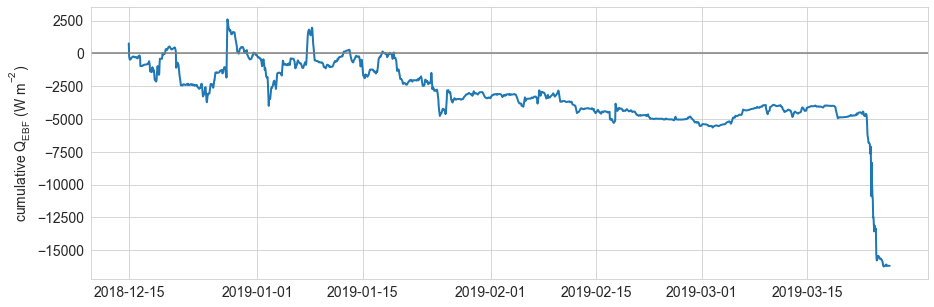

In [75]:
# Integrate EBF

EBF_sum = np.nancumsum(ebf)
plt.figure(figsize=[15,5])
plt.plot(time[:-1],EBF_sum,lw=2)
plt.axhline(0,c='Grey')
plt.ylabel('cumulative Q$_{EBF}$ (W m$^{-2}$)')

#plt.savefig('figures/cumulative_ebf',bbox_inches='tight',dpi=75)